# 震動訊號分析 - 入門

In [1]:
%load_ext autoreload
%autoreload 2
import os, warnings, sys, cv2
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import pandas as pd
from IPython.display import display
from IPython.display import HTML
sys.path.append('..')
#from utils import set_font_cn

In [4]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/bwZaUABt-j4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

## 為什麼大部分的CNC刀具壽命研究都是用震動數據？

中國軸承-朱翰緣博士
    - 只要是轉動就可以做震動分析 -> CNC的刀具剛好是轉動的機構
    - 不同頻率的震動代表不一樣的問題(ex: 轉速10倍的震動頻率通常是結構性的損壞, 100倍的通常是元件性的損壞)
    


## 震動訊號分析在做什麼?

- 從Data裡面找到規則, ex: 
    - 震動數據的振幅隨著刀具使用時間增加而變大
    - 震動數據的?特徵?隨著刀具使用時間增加而變大/變小      
<br>
- 把Domain Knolwedge轉換成規則, ex:
    - 轉速10倍的震動頻率通常是結構性的損壞
    - 100倍的通常是元件性的損壞

In [73]:
Fs=150                       # sampling rate取樣率 (每秒150個數據點)
Ts = 1.0/Fs                  # sampling interval 取樣區間 (每1/150秒取樣一次)
t = np.arange(0,1,Ts)        # time vector,這裡Ts也是步長
ff = 5                      # 頻率, 每秒5次
y1 = np.sin(2*np.pi*ff*t)     # Signal 

假設我們從傳感器擷取了一秒的震動數據, 這個刀具的震動數據的頻率是10Hz, 也就是每秒會震動10次

所以我們會從傳感器收到以下刀具正常運作的數據


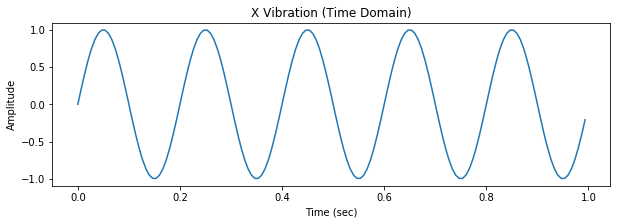

In [88]:
print('假設我們從傳感器擷取了一秒的震動數據, 這個刀具的震動數據的頻率是10Hz, 也就是每秒會震動10次')
print('\n所以我們會從傳感器收到以下刀具正常運作的數據')
plt.figure(figsize=(10,3))
plt.plot(t,y1)
plt.title('Normal Vibration (Time Domain)')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.show()

假設這個刀具的轉速是600 RPM(每分鐘60轉, 每秒10轉 (10Hz)), 而且這個刀具上面有一個小小的崩角, 這個崩角隨著刀具旋轉, 每轉一圈就會造成一個很大的震動

所以我們也會從傳感器收到以下刀具崩角造成的震動數據


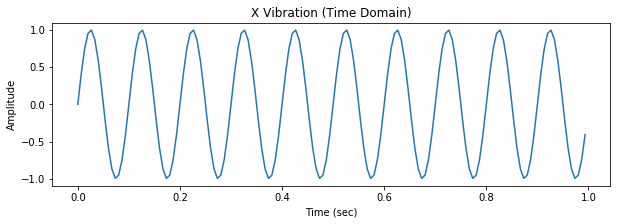

In [90]:
print('假設這個刀具的轉速是600 RPM(每分鐘60轉, 每秒10轉 (10Hz)), 而且這個刀具上面有一個小小的崩角, 這個崩角隨著刀具旋轉, 每轉一圈就會造成一個很大的震動')
print('\n所以我們也會從傳感器收到以下刀具崩角造成的震動數據')
ff = 10
y2 = np.sin(2*np.pi*ff*t)     # Defect Signal 
plt.figure(figsize=(10,3))
plt.plot(t,y2)
plt.title('Defect Vibration (Time Domain)')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.show()

因為傳感器會同時收到刀具正常的運作數據和崩角造成的損壞震動數據, 所以我們看到的震動數據應該是上面兩個數據的相加：



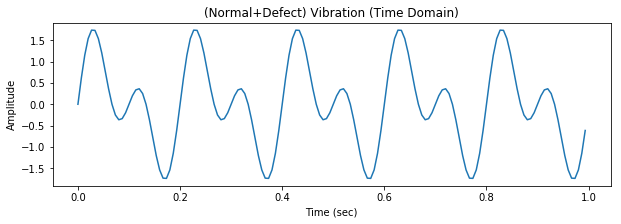

In [129]:
print('因為傳感器會同時收到刀具正常的運作數據和崩角造成的損壞震動數據, 所以我們看到的震動數據應該是上面兩個數據的相加：')

print('')
y=y1+y2
plt.figure(figsize=(10,3))
plt.plot(t,y)
plt.title('(Normal+Defect) Vibration (Time Domain)')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.show()


**時域分析**

In [154]:
def getrms(data):
    return np.sqrt(np.square(data).mean())

print('RMS:', np.round(getrms(y),2))
print('Max:', max(y))
print('min:', min(y))

RMS: 1.0
Max: 1.7376667208456693
min: -1.7376667208456675


**頻域分析**

但因為我們已經知道這份數據可能是有正常與Defect的震動成分組成的, 

這時候我們可以把數據做頻域分析(傅立葉轉換), 分析數據的頻率成分, 先把不同的成分拆開來, 再從各頻率的訊號裡面找規則


Text(0,0.5,'|Y(freq)|')

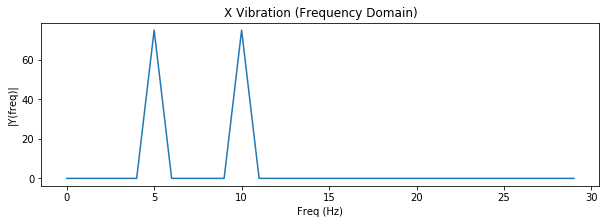

In [131]:
print('但因為我們已經知道這份數據可能是有正常與Defect的震動成分組成的, \n\n這時候我們可以把數據做頻域分析(傅立葉轉換), 分析數據的頻率成分, 先把不同的成分拆開來, 再從各頻率的訊號裡面找規則')
plt.figure(figsize=(10,3))
T=1
freq=np.arange(150)/T
freq_half = freq[:150//2]
Y_fft = np.fft.fft(y)
Y1 = Y_fft[range(150//2)]

plt.plot(freq_half[:30], abs(Y1[:30]))
plt.title('X Vibration (Frequency Domain)')
plt.xlabel('Freq (Hz)')
plt.ylabel('|Y(freq)|')

只擷取10Hz的訊號, 把Defect的訊號復原
RMS: 0.35
Max: 0.4972609476841378
min: -0.49726094768413726


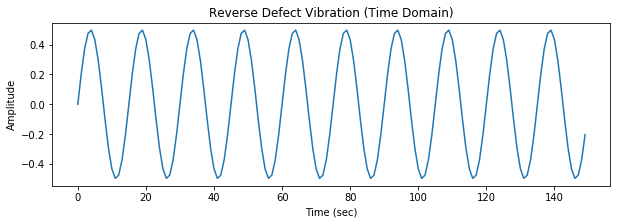

In [153]:
print('只擷取10Hz的訊號, 把Defect的訊號復原')
cut_f_signal = Y_fft.copy()
cut_f_signal[:7]=0
cut_f_signal[30:]=0
cut_signal = np.fft.ifft(cut_f_signal)
plt.figure(figsize=(10,3))
cut_signal_real = list(map(lambda x: x.real, cut_signal))
plt.plot(cut_signal_real)
plt.title('Reverse Defect Vibration (Time Domain)')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
print('RMS:', np.round(getrms(cut_signal_real),2))
print('Max:', max(cut_signal_real))
print('min:', min(cut_signal_real) )